In [1]:
##### Import Libraries
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score, matthews_corrcoef, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import cv2

In [2]:
### Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [3]:
### Custom Model 
class VGG16_Model(nn.Module):
    def __init__(self, num_classes, dropout_p=0.5, freeze_backbone=True):
        super().__init__()
        vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        if freeze_backbone:
            for param in vgg16.features.parameters():
                param.requires_grad = False
        self.features = vgg16.features
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

In [8]:
### Data Setup
data_dir = "./Diabetic-retinopathy/Dataset"
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
dataset_full = ImageFolder(data_dir)
print(dataset_full)

Dataset ImageFolder
    Number of datapoints: 3662
    Root location: ./Diabetic-retinopathy/Dataset


In [7]:
### Balance dataset
target_per_class = 3000
balanced_indices = []
class_to_indices = {cls_idx: [] for cls_idx in range(len(dataset_full.classes))}
for idx, (_, label) in enumerate(dataset_full.samples):
    class_to_indices[label].append(idx)

for cls, indices in class_to_indices.items():
    if len(indices) > target_per_class:
        chosen = random.sample(indices, target_per_class)
    else:
        chosen = np.random.choice(indices, target_per_class, replace=True).tolist()
    balanced_indices.extend(chosen)
balanced_dataset = Subset(dataset_full, balanced_indices)
print("Balanced dataset size:", len(balanced_dataset))
for cls in range(len(dataset_full.classes)):
    count = sum(1 for i in balanced_indices if dataset_full.samples[i][1] == cls)
    print(f"Class {dataset_full.classes[cls]}: {count}")

Balanced dataset size: 15000
Class Mild: 3000
Class Moderate: 3000
Class No_DR: 3000
Class Proliferate_DR: 3000
Class Severe: 3000


In [9]:
### Split dataset
val_size = int(0.2 * len(balanced_dataset))
test_size = int(0.1 * len(balanced_dataset))
train_size = len(balanced_dataset) - val_size - test_size
train_set, val_set, test_set = random_split(balanced_dataset, [train_size, val_size, test_size])
train_set.dataset.dataset.transform = train_transform
val_set.dataset.dataset.transform = val_test_transform
test_set.dataset.dataset.transform = val_test_transform

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

In [10]:
# ==== Model, Loss, Optimizer ====
num_classes = len(dataset_full.classes)
model = VGG16_Model(num_classes=num_classes, dropout_p=0.5).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.3, patience=3)

In [11]:
# ==== Training Functions ====
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total



In [12]:
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return running_loss / total, correct / total, all_labels, all_preds, np.array(all_probs)

In [13]:
# ==== Training Loop ====
num_epochs = 100
patience = 5
trigger_times = 0
best_loss = float("inf")
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_vgg16.pth")
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break

Epoch [1/100] Train Loss: 1.2245 Acc: 0.5516 | Val Loss: 0.9990 Acc: 0.7027
Epoch [2/100] Train Loss: 1.0010 Acc: 0.6925 | Val Loss: 0.8931 Acc: 0.7793
Epoch [3/100] Train Loss: 0.9129 Acc: 0.7484 | Val Loss: 0.8189 Acc: 0.8263
Epoch [4/100] Train Loss: 0.8471 Acc: 0.7952 | Val Loss: 0.7638 Acc: 0.8597
Epoch [5/100] Train Loss: 0.7922 Acc: 0.8291 | Val Loss: 0.7159 Acc: 0.8767
Epoch [6/100] Train Loss: 0.7616 Acc: 0.8440 | Val Loss: 0.6737 Acc: 0.8967
Epoch [7/100] Train Loss: 0.7231 Acc: 0.8660 | Val Loss: 0.6455 Acc: 0.9077
Epoch [8/100] Train Loss: 0.6884 Acc: 0.8878 | Val Loss: 0.6246 Acc: 0.9210
Epoch [9/100] Train Loss: 0.6728 Acc: 0.8944 | Val Loss: 0.6042 Acc: 0.9283
Epoch [10/100] Train Loss: 0.6456 Acc: 0.9093 | Val Loss: 0.5823 Acc: 0.9410
Epoch [11/100] Train Loss: 0.6325 Acc: 0.9163 | Val Loss: 0.5639 Acc: 0.9500
Epoch [12/100] Train Loss: 0.6195 Acc: 0.9235 | Val Loss: 0.5589 Acc: 0.9483
Epoch [13/100] Train Loss: 0.6090 Acc: 0.9293 | Val Loss: 0.5505 Acc: 0.9490
Epoch [1


Test Loss: 0.4409, Test Acc: 0.9827

Classification Report:
                precision    recall  f1-score   support

          Mild       0.98      0.99      0.99       301
      Moderate       0.99      0.96      0.98       295
         No_DR       0.99      1.00      1.00       301
Proliferate_DR       0.99      0.97      0.98       291
        Severe       0.96      0.99      0.98       312

      accuracy                           0.98      1500
     macro avg       0.98      0.98      0.98      1500
  weighted avg       0.98      0.98      0.98      1500

Cohen's Kappa: 0.9783273974483011
Matthews Correlation Coefficient: 0.9784008189725625
ROC AUC Score: 0.9983200138553145


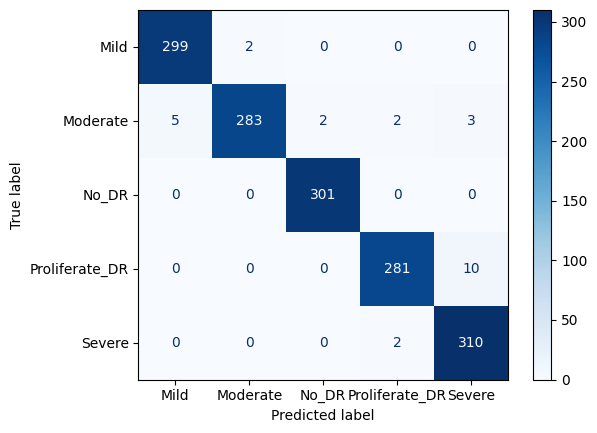

In [ ]:
# ==== Testing and Metrics ====
model.load_state_dict(torch.load("best_vgg16.pth"))
test_loss, test_acc, y_true, y_pred, y_prob = evaluate(model, test_loader, criterion)
print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=dataset_full.classes))
print("Cohen's Kappa:", cohen_kappa_score(y_true, y_pred))
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_true, y_pred))

try:
    roc_auc = roc_auc_score(y_true, y_prob, multi_class="ovr")
    print("ROC AUC Score:", roc_auc)
except Exception as e:
    print("ROC AUC Error:", e)

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=dataset_full.classes).plot(cmap=plt.cm.Blues)
plt.show()
###########################################################

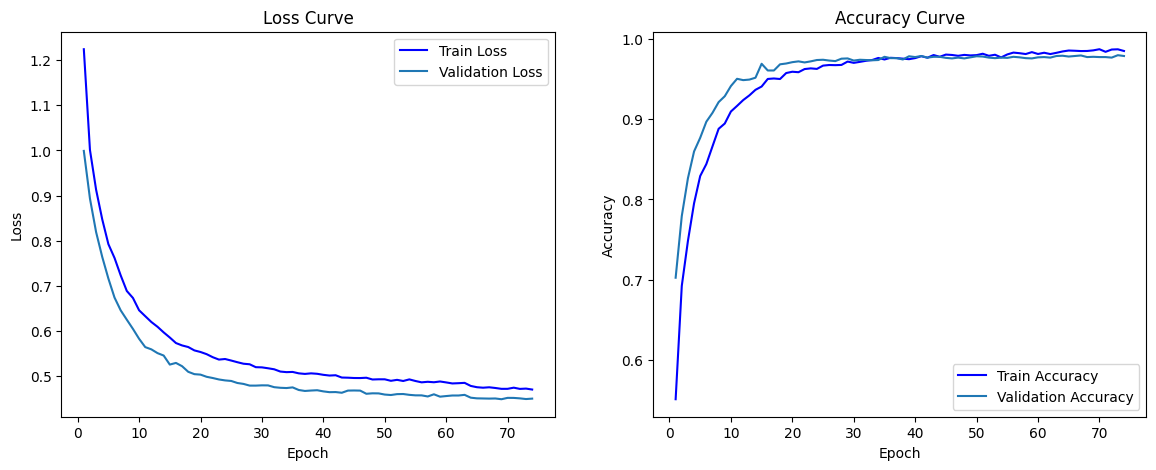

In [21]:
# ==== Learning Curves ====
def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label="Train Loss")
    plt.plot(epochs, val_losses, '-', label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label="Train Accuracy")
    plt.plot(epochs, val_accs, '-', label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.show()

plot_learning_curves(train_losses, val_losses, train_accs, val_accs)